In this project, we build an image segmentation neural network for the CIFAR-10 database, to which we apply Lipschitzian regularization in order to make the network firmly non-expansive, therefore reducing sensitivity to adverse perturbations.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets
from torchvision.models import resnet18
from torchvision.datasets import CIFAR10
from tqdm import tqdm_notebook as tqdm
from torchvision.utils import save_image, make_grid
from matplotlib import pyplot as plt
from matplotlib.colors import hsv_to_rgb
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox
import numpy as np
from IPython import display
import requests
import random
from io import BytesIO
from PIL import Image
from PIL import Image, ImageSequence
from IPython.display import HTML
import warnings
from matplotlib import rc
import gc
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
gc.enable()
plt.ioff()
!nvidia-smi # Utilisation d'un gpu

Sun Mar 24 16:53:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
num_classes = 10 #Classify images into 10 different classes
resnet = resnet18(pretrained=True) # Load ResNet-18 with pre-trained weights
resnet.conv1 = nn.Conv2d(3,64,3,stride=1,padding=1) #64 output channels for 1st layer to reduce parameters
resnet_ = list(resnet.children())[:-2] # Last 2 layers are average pooling and fully connected: not necessary for tiny ResNet
resnet_[3] = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
classifier = nn.Conv2d(512,num_classes,1)
torch.nn.init.kaiming_normal_(classifier.weight)
resnet_.append(classifier)
resnet_.append(nn.Upsample(size=32, mode='bilinear', align_corners=False))
tiny_resnet = nn.Sequential(*resnet_)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 107MB/s]


In [3]:
def attention(x):
    return torch.sigmoid(torch.logsumexp(x,1, keepdim=True))

The attention weights are used to focus on the most important parts of input $x$. In the next part, we first transform the training images by normalising them, then transforming them into tensors before normalising them again. We use the $\verb|noise_transform|$ to transform the test images by adding a Gaussian noise $\epsilon\sim\mathcal N(0,1)$ scaled by a factor $\alpha = 0.0005$ in our case. This is to test the robustness of our network.

In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=8),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = CIFAR10(root='.', train=True, download=True, transform=transform_train)
train_iter = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=16, pin_memory=True, drop_last=True)

# Définir la transformation pour ajouter du bruit gaussien

noise_transform =transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    #transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.05)
])

# Charger les données CIFAR-10 avec la transformation du bruit

testset = CIFAR10(root='.', train=False, download=True, transform=noise_transform)
test_iter = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False,num_workers=16, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170498071/170498071 [00:12<00:00, 13204935.96it/s]


Extracting ./cifar-10-python.tar.gz to .


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


The $\verb|jacobian_spectral_norm|$ function serves to calculate the spectral norm of the Jacobian of the reflection of the network, namely $\left \| J_{Q_\theta^\sigma}(x)\right\|_S$ where $Q_\theta^\sigma = 2 Q_\theta - I$, to measure the sensitivity of the output of the network to changes in the input, as the Gaussian noise $\epsilon \sim \mathcal{N}(0,1)$. This hinges on the Rademacher theorem, stating that $$L(Q_\theta^\sigma) = \sup_{x\in X} \left \| J_{Q_\theta^\sigma}(x)\right\|_S,$$ and $L(Q_\theta) \leqslant 2L(Q_\theta^\sigma)+1$ because if for a function $f \colon X \to Y$,
$$\|(2f-I)(x)-(2f-I)(y)\| = \|2(f(x)-f(y)) - (x-y)\|\leqslant (2L(f)+1)\|x-y\|.$$

Here, $\verb|max_it|$ denotes the maximum number of iterations to use in the power method (specified in the report of S6), while $\verb|interpolation|$ is a boolean value indicating whether to use interpolation to generate the input to the network.

The function first calculates the Jacobian of the network at the generated input, the latter being obtained by interpolating $\verb|y_in|$ and $\verb|x_hat|$. Using the power method, we calculate the spectral norm of the Jacobian.

In [5]:
model = nn.DataParallel(tiny_resnet).cuda()

def jacobian_spectral_norm(y_in, x_hat, interpolation=True, training=False, max_it=5):

    if interpolation:
        eta = torch.rand(y_in.size(0), 1, 1, 1, requires_grad=True).cuda()
        x = eta * y_in.detach() + (1 - eta) * x_hat.detach()
        x = x.cuda()     ##to(self.device)
    else:
        x = y_in

    x.requires_grad_()
    x_hat=model(x)          ###x_hat, _ = self.forward(x, sigma)


    if y_in.shape != x_hat.shape:  # We pad with zeros when output of network (x_hat) and input (y_in) don't have same shape
      zer_pad = torch.zeros_like(x_hat)
      y_in = torch.cat((y_in, zer_pad[:,y_in.shape[1]:,...]), 1)

    y = 2. * x_hat - y_in  # Beware notation: y_in = input, x_hat = output network

    u = torch.randn_like(x)
    u = u / torch.norm(u, p=2)

    z_old = torch.zeros(u.shape[0])

    for it in range(max_it):  ##self.hparams.power_method_nb_step=50
        w = torch.ones_like(y, requires_grad=True)  # Double backward trick. From https://gist.github.com/apaszke/c7257ac04cb8debb82221764f6d117ad
        v = torch.autograd.grad(torch.autograd.grad(y, x, w, create_graph=True), w, u, create_graph=training)[0]  # Ju
        v, = torch.autograd.grad(y, x, v, retain_graph=True, create_graph=True)  # vtJt

        z = torch.dot(u.flatten(), v.flatten()) / (torch.norm(u, p=2) ** 2)
        # z = torch.matmul(u.reshape(u.shape[0], 1, -1), v.reshape(v.shape[0], -1, 1)) / torch.matmul(u.reshape(u.shape[0], 1, -1), u.reshape(u.shape[0], -1, 1))

        if it > 0:
            rel_var = torch.norm(z - z_old)
            if rel_var < 1e-2:   #self.hparams.power_method_error_threshold=1e-2
                break
        z_old = z.clone()
        u = v / torch.norm(v, p=2)  # Modified

        if not training : #modifier self.eval
            w.detach_()
            v.detach_()
            u.detach_()

    return z.view(-1)


We are using a binary cross-entropy with logits loss function and an Adam optimizer for the weight optimization process. Here, $\verb|acces|$ stores the accuracies of the model during training.

We implement a Lipschitz constraint to regularize the model to make it more robust to noise such as $\epsilon$. After each batch, we calaculate the Lipschitz norm, and a loss term is added to the overall loss function, being $\lambda \max\left(\left \| J_{Q_\theta^\sigma}(x)\right\|_S, 1-\epsilon\right)$ to reduce the value of $\left \| J_{Q_\theta^\sigma}(x)\right\|_S$ below $1$.

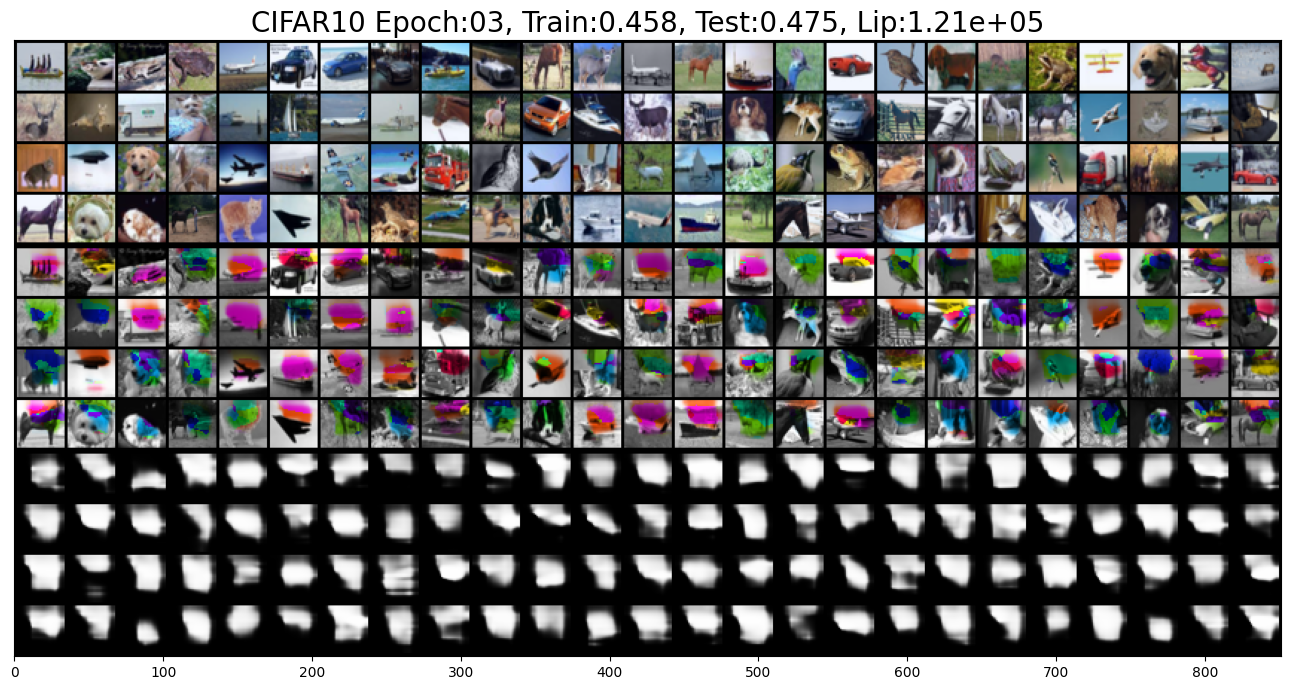

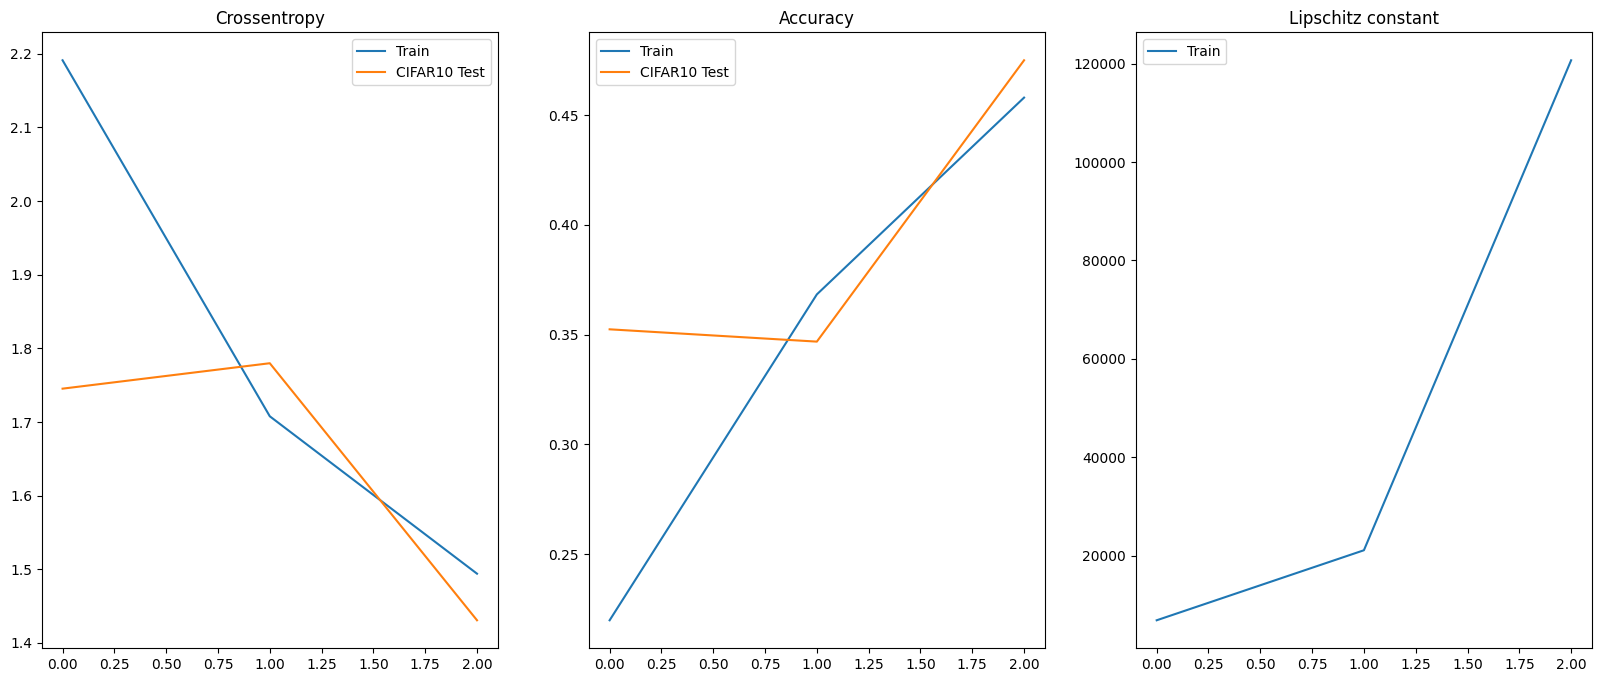

In [6]:
torch.cuda.empty_cache()  # for safety
model = nn.DataParallel(tiny_resnet).cuda()
num_epochs = 3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 78, eta_min=0.001)
jacobian_norms = []
losses = []
acces = []
v_losses = []
v_acces = []
plt.figure(figsize=(10, 6))
plt.title('Jacobian Norm')
for epoch in tqdm(range(num_epochs)):
    epoch_loss = 0.0
    acc = 0.0
    var = 0.0
    eps_jacobian_loss = 0.01
    jacobian_loss_weight = 1e-6
    jacobian_loss_type='max'
    jacobian_compute_type='nonsymmetric'
    model.train()
    train_pbar = tqdm(train_iter)
    for i, (x, _label) in enumerate(train_pbar):
        x = x.cuda()
        x.requires_grad_()  # Activate grad
        _label = _label.cuda()
        label = F.one_hot(_label).float()
        seg_out = model(x)
        attn = attention(seg_out)
        logit = torch.log(torch.exp(seg_out*0.5).mean((-2,-1)))*2
        loss = criterion(logit, label)
        #Contrainte de Lipschitz
        jacobian_norm = jacobian_spectral_norm(x[0:1], seg_out[0:1], interpolation=False, training=True)
        jacobian_loss = torch.maximum(jacobian_norm, torch.ones_like(jacobian_norm)-eps_jacobian_loss).mean()
        loss += jacobian_loss_weight * jacobian_loss
        loss = loss.mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        epoch_loss += loss.item()
        acc += (logit.argmax(-1)==_label).sum()

        train_pbar.set_description('Accuracy: {:.3f}%, Lip: {:.2e}'.format(100*(logit.argmax(-1)==_label).float().mean(), jacobian_norm.item()))

    avg_loss = epoch_loss / (i + 1)
    losses.append(avg_loss)
    jacobian_norms.append(jacobian_norm.item())
    avg_acc = acc.cpu().detach().numpy() / (len(trainset))
    acces.append(avg_acc)
    model.eval()
    epoch_loss = 0.0
    acc = 0.0
    num_seen = 0

    test_pbar = tqdm(test_iter)
    for i, (x, _label) in enumerate(test_pbar):
        x = x.cuda()
        _label = _label.cuda()
        label = F.one_hot(_label).float()
        seg_out = model(x)
        attn = attention(seg_out)
        logit = torch.log(torch.exp(seg_out*0.5).mean((-2,-1)))*2
        loss = criterion(logit, label)
        epoch_loss += loss.item()
        acc += (logit.argmax(-1)==_label).sum()
        num_seen += label.size(0)
        test_pbar.set_description('Accuracy: {:.3f}%, Lip: {:.2e}'.format(100*(acc.float()/num_seen), jacobian_norm.item()))

    avg_loss_val = epoch_loss / (i + 1)
    v_losses.append(avg_loss_val)
    avg_acc_val = acc.cpu().detach().numpy() / (len(testset))
    v_acces.append(avg_acc_val)
    plt.close('all')

    conf = torch.max(nn.functional.softmax(seg_out, dim=1), dim=1)[0]
    hue = (torch.argmax(seg_out, dim=1).float() + 0.5)/10
    x -= x.min()
    x /= x.max()
    gs_im = x.mean(1)
    gs_mean = gs_im.mean()
    gs_min = gs_im.min()
    gs_max = torch.max((gs_im-gs_min))
    gs_im = (gs_im - gs_min)/gs_max
    hsv_im = torch.stack((hue.float(), attn.squeeze().float(), gs_im.float()), -1)
    im = hsv_to_rgb(hsv_im.cpu().detach().numpy())
    ex = make_grid(torch.tensor(im).permute(0,3,1,2), normalize=True, nrow=25)
    attns = make_grid(attn, normalize=False, nrow=25)
    attns = attns.cpu().detach()
    inputs = make_grid(x, normalize=True, nrow=25).cpu().detach()
    display.clear_output(wait=True)
    plt.figure(figsize=(20,8))
    plt.imshow(np.concatenate((inputs.numpy().transpose(1,2,0),ex.numpy().transpose(1,2,0), attns.numpy().transpose(1,2,0)), axis=0))
    #plt.xticks(np.linspace(18,324,10), classes)
    #plt.xticks(fontsize=20)
    plt.yticks([])
    plt.title('CIFAR10 Epoch:{:02d}, Train:{:.3f}, Test:{:.3f}, Lip:{:.2e}'.format(epoch+1, avg_acc, avg_acc_val, jacobian_norm.item()), fontsize=20)
    display.display(plt.gcf())
    fig, ax = plt.subplots(1,3, figsize=(20,8))
    ax[0].set_title('Crossentropy')
    ax[0].plot(losses, label='Train')
    ax[0].plot(v_losses, label='CIFAR10 Test')
    ax[0].legend()
    ax[1].set_title('Accuracy')
    ax[1].plot(acces, label='Train')
    ax[1].plot(v_acces, label='CIFAR10 Test')
    ax[1].legend()
    ax[2].set_title('Lipschitz constant')
    ax[2].plot(jacobian_norms, label = 'Train')
    ax[2].legend()
    display.display(plt.gcf())